J =  [[-0.00907969  0.00892031]
 [-0.02192031 -0.02192031]]
gardN =  [[ 7.10542736e-15  4.56197923e+01]
 [-5.55555556e+01 -2.26079278e+01]
 [ 5.55555556e+01 -2.30118646e+01]] inv(J) =  [[-55.55555556 -22.60792776]
 [ 55.55555556 -23.01186458]]
det(J)/2 =  0.00019728279195104683
Ke =  [[ 21.76064094 -10.78398154 -10.9766594 ]
 [-10.78398154  37.61581564 -26.8318341 ]
 [-10.9766594  -26.8318341   37.8084935 ]]
J =  [[ 0.00892031  0.01272792]
 [-0.02192031 -0.01272792]]
gardN =  [[-55.55555556  23.01186458]
 [-76.92307692 -76.92307692]
 [132.47863248  53.91121235]] inv(J) =  [[-76.92307692 -76.92307692]
 [132.47863248  53.91121235]]
det(J)/2 =  8.273149339882605e-05
Ke =  [[ 15.85517469  10.9766594  -26.8318341 ]
 [ 10.9766594   51.89075917 -62.86741858]
 [-26.8318341  -62.86741858  89.69925267]]
zconn =  [[1 0]] 1
x1-x2 =  [[0.04384062]
 [0.031     ]]
length he =  0.023726372806635566
He =  [[1.18631864 0.59315932]
 [0.59315932 1.18631864]]
Lea = [[-12.45634572]
 [-12.45634572]]
K =  [[ 

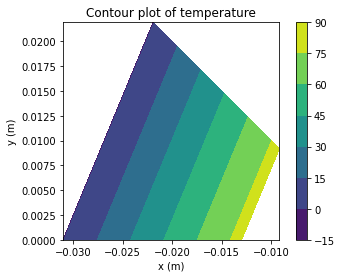

In [53]:
import math
from numpy import array as array 
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import arange as arange
from numpy import dot as dot
from numpy import linalg as linalg
from numpy import vstack  as vstack
from numpy import diff as diff
import matplotlib.pyplot as plt


ri = 0.013
ro = 0.031
k = 53  # thermal conductivity
Dz = 1.0  # thickness of the slice
h = 150  # surface heat transfer coefficient
Ta = -7.0  # ambient air temperature

# Coordinates of nodes
x = array([[-ro,0], [-ro*math.cos(45. / 180 * math.pi), ro*math.sin(45. / 180 * math.pi)], [-ri*math.cos(45. / 180 * math.pi), ri*math.sin(45. / 180 * math.pi)], [-ri,0]])

dof = array([2,1,4,3]) # degrees of freedom

N = 4 # Number of all degrees of freedom
N_f = 2 #As two of the temp values are known


Tw = 80.0 # Water Temperature 
T = zeros(N).reshape(N, 1)

T[N_f:N] = Tw #Nodes having constant temp value

gradNpar = array([[-1, -1], [1, 0], [0, 1]])

conn = array([[2,1,4], [2, 4, 3]]) #Connectivity matrix
connbdry = array([[2, 1]]) ## boundary connectivity

K = zeros((N_f, N))  # global conductivity matrix
L = zeros((N_f, 1))  # global heat loads vector

# Loop over the triangles in the mesh
zconn = conn - 1
for j  in arange(zconn.shape[0]):
    J = dot(x[zconn[j, :], :].T, gradNpar)# compute the Jacobian matr , x[zconn[j, :], :].T
    print("J = ",J)
    gradN = dot(gradNpar, linalg.inv(J)) # gradient wrt x y coordinate system
    print("gardN = ",gradN, "inv(J) = ",linalg.inv(J))
    Ke = (k*Dz*linalg.det(J)/2)*dot(gradN, gradN.T) # elementwise matrix
    print("det(J)/2 = ",linalg.det(J)/2)
    print("Ke = ",Ke)
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(dof[zconn[j, :]])-1
    # Assemble of conductivity matrix
    for i  in arange(len(zedof)):
        for j  in arange(len(zedof)):
            if (zedof[i] < N_f):
                K[zedof[i], zedof[j]] = K[zedof[i], zedof[j]] + Ke[i, j]
    

# Calculations for the  convection boundary condition
H = zeros((N_f, N))  # global film-condition matrix
zconn = connbdry - 1
print("zconn = ",zconn,zconn.shape[0] )
for j in arange(zconn.shape[0]):
    he = linalg.norm(diff(x[zconn[j, :], :], axis=0))
    print("x1-x2 = ",diff(x[zconn[j, :], :]))
    print("length he = ",he)
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(dof[zconn[j, :]]) - 1
    He = h * Dz * he / 6 * array([[2, 1], [1, 2]])
    print("He = ",He)
    # Assemble elementwise surface heat transfer matrix
    for i in arange(len(zedof)):
        for j in arange(len(zedof)):
            if (zedof[i] < N_f):
                H[zedof[i], zedof[j]] = H[zedof[i], zedof[j]] + He[i, j]
    # Assemble elementwise heat load vector for surface heat transfer
    Lea = Ta * h * he * Dz / 2 * array([[1], [1]])
    print("Lea =",Lea)
    for i in arange(len(zedof)):
        if (zedof[i] < N_f):
            L[zedof[i]] = L[zedof[i]] + Lea[i]

# Solve for the global temperatures at the free degrees of freedom
print("K = ",K)
print("H = ",H)
print(L)
# Solve for the global temperatures at the free degrees of freedom
T[0:N_f] = linalg.solve(K[0:N_f, 0:N_f] + H[0:N_f, 0:N_f], L)
print("Hfinal = ", H[0:N_f, 0:N_f])
print("Kfinal = ", K[0:N_f, 0:N_f])
print("H + K = ",K[0:N_f, 0:N_f] + H[0:N_f, 0:N_f])
print('T=', T)

print('Temperatures at the nodes')
for index in arange(dof.shape[0]):
    print('Node', index + 1, 'T=', T[dof[index] - 1])

# Plot filled contours
plt.figure()
plt.gca().set_aspect('equal')
# setup three 1-d arrays for the x-coordinate, the y-coordinate, and the
# z-coordinate
xs = x[:, 0].reshape(N,)  # one value per node
ys = x[:, 1].reshape(N,)  # one value per node
ix = dof[arange(N)] - 1
print(ix)
zs = (T[ix]).reshape(N,) # one value per node
triangles = conn - 1  # the triangles are defined by the connectivity arrays
plt.tricontourf(xs, ys, triangles, zs)
plt.colorbar()
plt.title('Contour plot of temperature')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [66]:
import numpy as np
Temp = [[-0.43536437],[-0.43536437],[80.0]]
gardN =  [[7.10542736e-15 , 4.56197923e+01],
 [-5.55555556e+01, -2.26079278e+01],
 [ 5.55555556e+01 ,-2.30118646e+01]]
q = dot(np.transpose(Temp),gradN)
print(q)
Q = -k*np.transpose(q)
print(Q)


[[10655.96707466  4336.36800874]]
[[-564766.25495688]
 [-229827.50446337]]


In [67]:
import numpy as np
Temp = [[-0.43536437],[80.0],[80.0]]
gardN =  [[-55.55555556 , 23.01186458],[-76.92307692 ,-76.92307692],[132.47863248 ,53.91121235]]
q = dot(np.transpose(Temp),gradN)
print(q)
Q = -k*np.transpose(q)
print(Q)

[[ 4468.63135389 -1850.96771203]]
[[-236837.46175611]
 [  98101.2887374 ]]


x[zconn[j, :], :] =  [[0.   0.05]
 [0.   0.  ]
 [0.05 0.05]]
Jacobian =  [[ 0.    0.05]
 [-0.05  0.  ]]
Inv Jacobian =  [[ -0. -20.]
 [ 20.   0.]]
gradNL =  [[-20.  20.]
 [  0. -20.]
 [ 20.   0.]]
det(J) =  0.0025000000000000005
Ke =  [[ 0.05  -0.025 -0.025]
 [-0.025  0.025  0.   ]
 [-0.025  0.     0.025]]
zedof =  [4 2 1]
K =  [[ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.025  0.   ]]
K =  [[ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.    -0.025  0.   ]]
K =  [[ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.025  0.     0.    -0.025  0.   ]]
x[zconn[j, :], :] =  [[0.05 0.  ]
 [0.05 0.05]
 [0.   0.  ]]
Jacobian =  [[ 0.   -0.05]
 [ 0.05  0.  ]]
Inv Jacobian =  [[  0.  20.]
 [-20.  -0.]]
gradNL =  [[ 20. -20.]
 [  0.  20.]
 [-20.   0.]]
det(J) =  0.0025000000000000005
Ke =  [[ 0.05  -0.025 -0.025]
 [-0.025  0.025  0.   ]
 [-0.025  0.     0.025]]
zedof =  [0 1 2]
K =  [[ 0.05   0.     0.     0.     0.     0.   ]
 [ 0.     0.

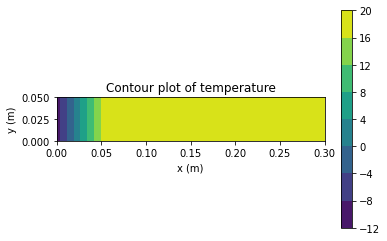

In [12]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
"""
Layered wall.  Temperature boundary conditions.
"""

import math
from numpy import array as array
from numpy import zeros as zeros
from numpy import ones as ones
from numpy import arange as arange
from numpy import dot as dot
from numpy import linalg as linalg
from numpy import vstack  as vstack
import matplotlib.pyplot as plt

Dz = 1.0 # Thickness of the slice (it cancels out  in the end)
kappaL = 0.05  # thermal conductivity, layer on the left
kappaR = 1.8  # thermal conductivity, layer on the right

t1, t2 , w = 0.05 , 0.25 , 0.05
# Coordinates of nodes
x = array([[0, 0], [t1, 0], [t1 + t2, 0], [0, w], [t1, w], [t1 + t2, w]])
N = 6 # total number of nodes
N_f = 2 # total number of free degrees of freedom
# Mapping from nodes to  degrees of freedom
node2dof = array([3, 1, 4, 5, 2, 6])

# Connectivity of the left-region triangles (polyurethane)
connL = array([[4, 1, 5], [2, 5, 1]])
# Connectivity of the right-region triangles (concrete)
connR = array([[6, 5, 2], [2, 3, 6]])
pTe = -10  # Boundary conditions, exterior, interior, deg Celsius
pTi = +20
T = zeros(N).reshape(N, 1)
# Apply fixed temperatures at the left-hand side face
for index  in [1, 4]:
    T[node2dof[index-1]-1] = pTe # left face, nodes 1 and 4

# Apply fixed temperatures at the right-hand side face
for index  in [3, 6]:
    T[node2dof[index-1]-1] = pTi # right face, nodes 3 and 6

# gradients of the basis functions with respect to the param. coordinates
gradNpar = array([[-1, -1], [1, 0], [0, 1]])

K = zeros((N_f, N)) # allocate the global conductivity matrix
LQ = zeros(N_f).reshape(N_f, 1)  # allocate the global heat loads vector

# Loop over the triangles in the mesh, left domain
kappa = kappaL
zconn = array(connL)-1
for j  in arange(zconn.shape[0]):
    print("x[zconn[j, :], :] = ", x[zconn[j, :], :])
    J = dot(x[zconn[j, :], :].T, gradNpar) # compute the Jacobian matrix
    print("Jacobian = ",J)
    print("Inv Jacobian = ",linalg.inv(J))
    gradN = dot(gradNpar, linalg.inv(J)) # compute the x,y grads of the b. funcs
    print("gradNL = ", gradN)
    print("det(J) = ",linalg.det(J))
    Ke = (kappa*Dz*linalg.det(J)/2)*dot(gradN, gradN.T) # elementwise matrix
    print("Ke = ",Ke)
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(node2dof[zconn[j, :]])-1
    print("zedof = ", zedof)
    # Assemble elementwise conductivity matrix
    for ro  in arange(len(zedof)):
        for co  in arange(len(zedof)):
            if (zedof[ro] < N_f):
                K[zedof[ro], zedof[co]] = K[zedof[ro], zedof[co]] + Ke[ro, co]
                print("K = ",K)

# Loop over the triangles in the mesh, right domain
kappa = kappaR
zconn = array(connR)-1
print("zconn.shape[0] = ", zconn.shape[0])
for j  in arange(zconn.shape[0]):
    print("x[zconn[j, :], :] = ", x[zconn[j, :], :])
    J = dot(x[zconn[j, :], :].T, gradNpar) # compute the Jacobian matrix
    print("Jacobian = ",J)
    print("Inv Jacobian = ",linalg.inv(J))
    gradN = dot(gradNpar, linalg.inv(J)) # compute the x,y grads of the b. funcs
    print("gradNR = ", gradN)
    print("det(J) = ",linalg.det(J))
    Ke = (kappa*Dz*linalg.det(J)/2)*dot(gradN, gradN.T) # elementwise matrix
    print("Ke = ",Ke)
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(node2dof[zconn[j, :]])-1
    # Assemble elementwise conductivity matrix
    for ro  in arange(len(zedof)):
        for co  in arange(len(zedof)):
            if (zedof[ro] < N_f):
                K[zedof[ro], zedof[co]] = K[zedof[ro], zedof[co]] + Ke[ro, co]
                print("K = ",K)

print(K)
# Compute loading from the prescribed temperatures
print("K[0:N_f, N_f:N], T[N_f:N] = ",K[0:N_f, N_f:N], T[N_f:N])
LT = -dot(K[0:N_f, N_f:N], T[N_f:N])
print(LT)
# Solve for the global temperatures at the free degrees of freedom
T[0:N_f] = linalg.solve(K[0:N_f, 0:N_f], LQ + LT)
print('T=', T)

for index in arange(node2dof.shape[0]):
    print('Node', index + 1, 'T=', T[node2dof[index] - 1])

# Plotting: produce a contour plot of the temperature on the mesh
plt.figure()
plt.gca().set_aspect('equal')
# setup three 1-d arrays for the x-coord, the y-coord, and the z-coord
xs = x[:, 0].reshape(N,)# one value per node
ys = x[:, 1].reshape(N,)# one value per node
ix = node2dof[arange(N)]-1 # The number of the DOF for each node, zero-based
zs = T[ix].reshape(N,) # one value per node
triangles = vstack((connL-1, connR-1))# triangles are defined by conn arrays
plt.tricontourf(xs, ys, triangles, zs)
plt.colorbar()
plt.title('Contour plot of temperature')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()

In [39]:
import numpy as np
from numpy.linalg import norm
import math
Temp = [[16.34146341],[16.34146341],[-10.0]]
k = 0.05
gradN =   [[20. , -20.],
 [  0., 20.],
 [ -20. ,  0.]]
q = np.dot(np.transpose(Temp),gradN)
print(q)
Q = -k*np.transpose(q)
print(Q)
Qn = norm(Q) 
print(Qn)

[[ 5.26829268e+02 -1.42108547e-14]]
[[-2.63414634e+01]
 [ 7.10542736e-16]]
26.341463410000003


[[ 2.51451863 -2.0875     -0.39130435  0.         -0.03571429  0.        ]
 [-2.0875      2.51451863  0.         -0.39130435  0.         -0.03571429]
 [-0.39130435  0.          2.46130435 -2.07        0.          0.        ]
 [ 0.         -0.39130435 -2.07        2.46130435  0.          0.        ]]
[[-0.35714286]
 [-0.35714286]
 [-0.        ]
 [-0.        ]]
[[-0.35714286]
 [-0.35714286]
 [-1.5       ]
 [-1.5       ]]
T= [[-52.        ]
 [-52.        ]
 [-55.83333333]
 [-55.83333333]
 [-10.        ]
 [-10.        ]]


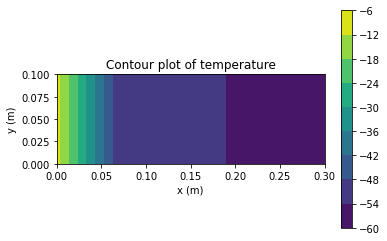

In [3]:
# Finite Element Modeling with Abaqus and Python for Thermal and
# Stress Analysis
# (C)  2017-2020, Petr Krysl
#
"""
 Layered wall.  Temperature boundary condition on the left, and heat flux
 boundary condition on the right.
 """

from numpy import array as array
from numpy import zeros as zeros
from numpy import arange as arange
from numpy import dot as dot
from numpy import linalg as linalg
from numpy import vstack  as vstack
from numpy import diff as diff
import matplotlib.pyplot as plt


Dz = 1.0 # Thickness of the slice (it cancels out  in the end)
kappaL = 0.05  # thermal conductivity, layer on the left
kappaR = 1.8  # thermal conductivity, layer on the right
# Coordinates of nodes
x = array([[0, 0], [0.07, 0], [0.3, 0], [0, 0.1], [0.07, 0.1], [0.3, 0.1]])
N = 6 # total number of nodes
N_f = 4 # total number of free degrees of freedom
# Mapping from nodes to  degrees of freedom
node2dof = array([5, 1, 3, 6, 2, 4])

# Connectivity of the left-region triangles (polyurethane)
connL = array([[4, 1, 5], [2, 5, 1]])
# Connectivity of the right-region triangles (concrete)
connR = array([[6, 5, 2], [2, 3, 6]])
# Connectivity  of the boundary L2 element  on the right
connRbdry = array([[3, 6]])
pTe = -10  # Boundary conditions, exterior, interior, deg Celsius
T = zeros(N).reshape(N, 1)
for index  in [1, 4]:
    T[node2dof[index-1]-1] = pTe # left face with EBC, nodes 1 and 4
qnbarR = 30 # prescribed heat flux at the right boundary

# gradients of the basis functions with respect to the param. coordinates
gradNpar = array([[-1, -1], [1, 0], [0, 1]])

K = zeros((N_f, N)) # allocate the global conductivity matrix
Lq = zeros(N_f).reshape(N_f, 1)  # allocate the global heat loads vector

# Loop over the triangles in the mesh, left domain
kappa = kappaL
zconn = array(connL)-1
for j  in arange(zconn.shape[0]):
    J = dot(x[zconn[j, :], :].T, gradNpar) # compute the Jacobian matrix
    gradN = dot(gradNpar, linalg.inv(J)) # compute the x,y grads of the b. funcs
    Ke = (kappa*Dz*linalg.det(J)/2)*dot(gradN, gradN.T) # elementwise matrix
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(node2dof[zconn[j, :]])-1
    # Assemble elementwise conductivity matrix
    for ro  in arange(len(zedof)):
        for co  in arange(len(zedof)):
            if (zedof[ro] < N_f):
                K[zedof[ro], zedof[co]] = K[zedof[ro], zedof[co]] + Ke[ro, co]

# Loop over the triangles in the mesh, right domain
kappa = kappaR
zconn = array(connR)-1
for j  in arange(zconn.shape[0]):
    J = dot(x[zconn[j, :], :].T, gradNpar) # compute the Jacobian matrix
    gradN = dot(gradNpar, linalg.inv(J)) # compute the x,y grads of the b. funcs
    Ke = (kappa*Dz*linalg.det(J)/2)*dot(gradN, gradN.T) # elementwise matrix
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(node2dof[zconn[j, :]])-1
    # Assemble elementwise conductivity matrix
    for ro  in arange(len(zedof)):
        for co  in arange(len(zedof)):
            if (zedof[ro] < N_f):
                K[zedof[ro], zedof[co]] = K[zedof[ro], zedof[co]] + Ke[ro, co]

# Boundary element heat flux term
qnbar = qnbarR
zconn = connRbdry - 1
for j  in arange(zconn.shape[0]):
    he = linalg.norm(diff(x[zconn[j, :], :], axis=0))
    # Element degree-of-freedom array,  converted to zero base
    zedof = array(node2dof[zconn[j, :]])-1
    Leq = -qnbar*he*Dz/2*array([[1], [1]])
    # Assemble elementwise heat load vector
    for ro  in arange(len(zedof)):
        if (zedof[ro] < N_f):
            Lq[zedof[ro]] = Lq[zedof[ro]] + Leq[ro]

print(K)
# Compute loading from the prescribed temperatures
LT = -dot(K[0:N_f, N_f:N], T[N_f:N])
print(LT)
print(Lq + LT)
# Solve for the global temperatures at the free degrees of freedom
T[0:N_f] = linalg.solve(K[0:N_f, 0:N_f], Lq + LT)
print('T=', T)

# Plotting
plt.figure()
plt.gca().set_aspect('equal')
# setup three 1-d arrays for the x-coord, the y-coord, and the z-coordinate
xs = x[:, 0].reshape(N,)# one value per node
ys = x[:, 1].reshape(N,)# one value per node
ix = node2dof[arange(N)]-1
zs = (T[ix]).reshape(N,)# one value per node
triangles = vstack((connL-1, connR-1))# triangles are defined by the conn arrays
plt.tricontourf(xs, ys, triangles, zs)
plt.colorbar()
plt.title('Contour plot of temperature')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.show()